# Demonstration for Building TSGM
Note that this file uses Allensville environment in **gibson_tiny**  and you should prepare the dataset (glb, navmesh) in your habitat-lab scene_datasets path for running this demonstration.

For visualization, please set the **display port** with your own. 
* os.environ['DISPLAY'] = 'localhost:10.0'



In [1]:
%matplotlib inline
import os
project_dir = os.getcwd()
project_dir = "/".join(project_dir.split("/")[:-1])
os.chdir(project_dir)

"""
Set the display port!!
"""
os.environ['DISPLAY'] = 'localhost:10.0'
"""
Set the display port!!
"""

import torch
import cv2, glob
from PIL import Image
from tqdm import tqdm 
import quaternion as q
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import habitat, habitat_sim
habitat_path = habitat.__path__[0]
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import torchvision.transforms as transforms
import torch.nn as nn
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
from utils.habitat_settings import default_sim_settings, make_cfg
eval_augmentation = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
from utils.statics import CATEGORIES, COI_INDEX
from matplotlib import animation
from IPython.display import HTML
from scipy.ndimage.interpolation import rotate
import imageio
from habitat.utils.visualizations import utils, fog_of_war

**Check that the project directory indicates the correct path**

In [2]:
project_dir

'/home/blackfoot/codes/TSGM'

In [3]:
from model.Graph.resnet_img import resnet18 as resnet18_img
img_encoder = resnet18_img(num_classes=512)
dim_mlp = img_encoder.fc.weight.shape[1]
img_encoder.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), img_encoder.fc)
ckpt_pth = os.path.join(project_dir, 'data/graph', 'Img_encoder.pth.tar')
ckpt = torch.load(ckpt_pth, map_location='cpu')
img_encoder.load_state_dict(ckpt)
img_encoder.eval().cuda()
def get_image_feat(rgb, depth, num_of_camera=12):
    img_tensor = torch.cat((torch.tensor(rgb[None]).cuda().float() / 255.,
                            torch.tensor(depth[None,...,None]).cuda().float()), 3).permute(0, 3, 1, 2)
    feat = img_encoder(img_tensor)
    vis_embedding = nn.functional.normalize(feat, dim=1)
    return vis_embedding

In [4]:
from model.Graph.resnet_obj import resnet18 as resnet18_obj
feature_dim = 32
object_encoder = resnet18_obj(num_classes=feature_dim)
dim_mlp = object_encoder.fc.weight.shape[1]
object_encoder.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), object_encoder.fc)
ckpt_pth = os.path.join(project_dir, 'data/graph', 'Obj_encoder.pth.tar')
ckpt = torch.load(ckpt_pth, map_location='cpu')
state_dict = {k[len('module.encoder_k.'):]: v for k, v in ckpt['state_dict'].items() if 'module.encoder_k.' in k}
object_encoder.load_state_dict(state_dict)
object_encoder.eval().cuda()
def get_object_feat(rgb, bboxes, num_of_camera=12):
    image = eval_augmentation(Image.fromarray(rgb.astype(np.uint8)))[None].cuda().float()
    feat = object_encoder(image, torch.tensor(np.concatenate((np.zeros([len(bboxes), 1]), bboxes), -1)).cuda()[None].float())[0]
    feat = nn.functional.normalize(feat, dim=1)
    return feat

In [5]:
settings = default_sim_settings.copy()
settings["max_frames"] = 100
settings["width"] = 256
settings["height"] = 256
settings["scene"] = ''
settings["save_png"] = False  # args.save_png
settings["sensor_height"] = 0.88
settings["color_sensor"] = True
settings["semantic_sensor"] = True
settings["depth_sensor"] = True
settings["print_semantic_scene"] = False
settings["print_semantic_mask_stats"] = False
settings["compute_shortest_path"] = False
settings["compute_action_shortest_path"] = False
settings["panoramic_sensor"] = True
settings["seed"] = 2343
settings["silent"] = False
settings["enable_physics"] = True
settings["draw_lidar"] = False
settings["agent_radius"] = 0.1
settings["agent_height"] = 1.2
settings["multiview"] = False
settings["hfov"] = 90
settings["FORWARD_STEP_SIZE"] = 0.25
settings["TURN_ANGLE"] = 10
settings["tdv_height"] = 512
settings["tdv_width"] = 512
settings["allow_sliding"] = True
num_of_camera = 12
pano_img_height = settings["height"]//2
img_height = pano_img_height
img_width = float(img_height * 4)
cam_width = float(pano_img_height * 4 // num_of_camera)
settings["cam_width"] = cam_width
settings["pano_height"] = pano_img_height

dataset = 'gibson_tiny'
scan_name = "Allensville"
if dataset == "mp3d":
    settings["scene"] = os.path.join(habitat_path, '../data/scene_datasets/{}/{}/{}.glb'.format(dataset, scan_name, scan_name))
elif "gibson" in dataset:
    settings["scene"] = os.path.join(habitat_path, '../data/scene_datasets/{}/{}.glb'.format(dataset, scan_name))
elif dataset == "hm3d":
    path = glob.glob(os.path.join(habitat_path, '../data/scene_datasets/{}/*/{}/{}.glb'.format(dataset, "*" + scan_name, scan_name)))[0]
    settings["scene"] = path
cfg = make_cfg(settings)

try:
    sim.close()
except:
    pass

sim = habitat_sim.Simulator(cfg)

I1013 23:43:28.634994 1393874 simulator.py:221] Loaded navmesh /home/blackfoot/programs/habitat-lab-021/habitat/../data/scene_datasets/gibson_tiny/Allensville.navmesh
I1013 23:43:23.612062 1393874 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1013 23:43:23.612089 1393874 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1013 23:43:23.612149 1393874 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1013 23:43:23.612182 1393874 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and re

sim_cfg.physics_config_file = ./data/default.physics_config.json
Renderer: NVIDIA GeForce GTX TITAN X/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.54
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


istered.
I1013 23:43:23.612318 1393874 AssetAttributesManager.cpp:120] Asset attributes (icosphereWireframe : icosphereWireframe_subdivs_1) created and registered.
I1013 23:43:23.612332 1393874 AssetAttributesManager.cpp:120] Asset attributes (uvSphereSolid : uvSphereSolid_rings_8_segments_16_useTexCoords_false_useTangents_false) created and registered.
I1013 23:43:23.612346 1393874 AssetAttributesManager.cpp:120] Asset attributes (uvSphereWireframe : uvSphereWireframe_rings_16_segments_32) created and registered.
I1013 23:43:23.612352 1393874 AssetAttributesManager.cpp:108] ::constructor : Built default primitive asset templates : 12
I1013 23:43:23.612874 1393874 SceneDatasetAttributesManager.cpp:36] File (default) not found, so new default dataset attributes created and registered.
I1013 23:43:23.612877 1393874 MetadataMediator.cpp:127] ::createSceneDataset : Dataset default successfully created.
I1013 23:43:23.612884 1393874 AttributesManagerBase.h:365] <Physics Manager>::createFrom

scan_name:  Allensville
floor:  0
lower_bound:  [-1.001614   -0.02151728 -7.8464866 ]
upper_bound:  [8.737579  4.0813746 1.0040159]
imgWidth:  1375
imgHeight:  1249


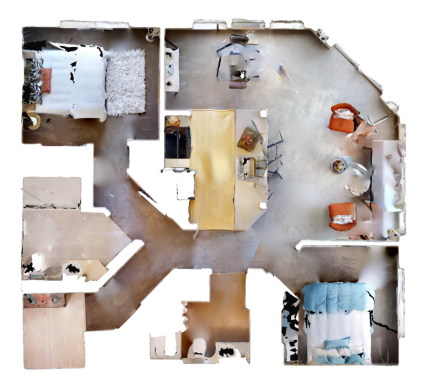

In [6]:
max_object = 10
bounds = sim.pathfinder.get_bounds()
scene_objects = sim.semantic_scene.objects
if dataset == "mp3d":
    mapping = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene_objects if obj != None}
elif dataset == "hm3d":
    mapping = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene_objects if obj != None}
else:
    mapping = {int(obj.id.split("_")[-1]): int(np.where([obj.category.name() == cat for cat in CATEGORIES['gibson']])[0][0]) for obj in scene_objects if obj != None}

set_floor = 0
floor = -1
num_try = 0
render_configs = joblib.load(os.path.join(project_dir, f"data/floorplans/{dataset}_floorplans/render_config.pkl"))
while floor != set_floor:
    init_position = sim.pathfinder.get_random_navigable_point()
    floor =  int(np.argmin([abs(float(render_configs[scan_name][i]['z_low']) - init_position[1]) for i in render_configs[scan_name].keys()]))
    num_try += 1
    if num_try > 100:
        print("Cannot find a valid position")
        break
init_rotation = sim.get_agent(0).get_state().rotation.components
scene_file = settings["scene"]

sim.reset()
agent = sim.initialize_agent(0)
start_state = agent.get_state()
if (start_state.position != init_position).any():
    start_state.position = init_position
    start_state.rotation = q.from_float_array(init_rotation)  # self.init_rotation #
    start_state.sensor_states = dict()  ## Initialize sensori
agent.set_state(start_state)
prev_position = agent.get_state().position
prev_rotation = q.as_euler_angles(agent.state.rotation)[1]

P = render_configs[scan_name][floor]['Projection']
lower_bound, upper_bound = sim.pathfinder.get_bounds()
imgWidth = round(float(render_configs[scan_name][floor]['width']))
imgHeight = round(float(render_configs[scan_name][floor]['height']))
world_min_width = float(render_configs[scan_name][floor]['x_low'])
world_max_width = float(render_configs[scan_name][floor]['x_high'])
world_min_height = float(render_configs[scan_name][floor]['y_low'])
world_max_height = float(render_configs[scan_name][floor]['y_high'])
worldWidth = abs(world_min_width) + abs(world_max_width)
worldHeight = abs(world_min_height) + abs(world_max_height)

print('====================================')
print('scan_name: ', scan_name)
print('floor: ', floor)
print('lower_bound: ', lower_bound)
print('upper_bound: ', upper_bound)
print('imgWidth: ', imgWidth)
print('imgHeight: ', imgHeight)

ortho_map = cv2.imread(os.path.join(project_dir, f"data/floorplans/{dataset}_floorplans/rgb/{scan_name}_level_{floor}.png"))[...,::-1][...,:3]
ortho_mask = cv2.imread(os.path.join(project_dir, f"data/floorplans/{dataset}_floorplans/mask/{scan_name}_level_{floor}.png"), 0)
ortho_map[ortho_mask==0] = 255
plt.axis("off")
plt.imshow(ortho_map)

In [7]:
scene_objects = sim.semantic_scene.objects
object_loc = {int(obj.id.split("_")[-1]): obj.aabb.center for obj in scene_objects if obj != None}

In [8]:
class ImgGraph(object):
    def __init__(self):
        self.feature_dim = 512
        self.M = 100

    def num_node(self):
        return len(self.node_position_list)

    def reset(self):
        self.node_position_list = []  # This position list is only for visualizations
        self.node_rotation_list = []  # This rotation list is only for visualizations
        self.graph_memory = np.zeros([self.M, self.feature_dim])
        self.A = np.zeros([self.M, self.M], dtype=np.bool)
        self.graph_mask = np.zeros(self.M)
        self.graph_time = np.zeros(self.M)
        self.last_localized_node_idx = np.zeros([1], dtype=np.int32)
        self.last_localized_node_embedding = np.zeros([self.feature_dim], dtype=np.float32)

    def initialize_graph(self, new_embeddings, positions, rotations):
        self.add_node(node_idx=0, embedding=new_embeddings, time_step=0, position=positions, rotation=rotations)
        self.record_localized_state(node_idx=0, embedding=new_embeddings)

    def add_node(self, node_idx, embedding, time_step, position, rotation):
        self.node_position_list.append(position)
        self.node_rotation_list.append(rotation)
        self.graph_memory[node_idx] = embedding
        self.graph_mask[node_idx] = 1.0
        self.graph_time[node_idx] = time_step

    def record_localized_state(self, node_idx, embedding):
        self.last_localized_node_idx = node_idx
        self.last_localized_node_embedding = embedding

    def add_edge(self, node_idx_a, node_idx_b):
        self.A[node_idx_a, node_idx_b] = True
        self.A[node_idx_b, node_idx_a] = True

    def update_node(self, node_idx, time_info, embedding=None):
        if embedding is not None:
            self.graph_memory[node_idx] = embedding
        self.graph_time[node_idx] = time_info

    def get_positions(self, a=None):
        if a is None:
            return self.node_position_list
        else:
            return self.node_position_list[a]

    def get_neighbor(self, node_idx, return_mask=False):
        if return_mask:
            return self.A[node_idx]
        else:
            return np.where(self.A[node_idx])[0]

In [9]:
class ObjGraph(object):
    def __init__(self,):
        self.feature_dim = 32
        self.M = 1000
        self.MV = 100

    def num_node(self):
        return len(self.node_position_list)

    def reset(self):
        self.node_position_list = []  # This position list is only for visualizations
        self.graph_memory = np.zeros([self.M, self.feature_dim])
        self.graph_category = np.zeros([self.M])
        self.graph_score = np.zeros([self.M])
        self.A_OV = np.zeros([self.M, self.MV], dtype=np.bool)
        self.graph_mask = np.zeros(self.M)
        self.graph_time = np.zeros([self.M], dtype=np.int32)
        self.last_localized_node_idx = 0

    def initialize_graph(self, new_embeddings, object_scores, object_categories, masks, positions):
        if sum(masks == 1) == 0:
            masks[0] = 1
        self.add_node(node_idx=0, embedding=new_embeddings, object_score=object_scores, object_category=object_categories, time_step=0, mask=masks, position=positions, vis_node_idx=0)

    def add_node(self, node_idx, embedding, object_score, object_category, mask, time_step, position, vis_node_idx):
        node_idx_ = node_idx
        i = 0
        while True:
            if mask[i] == 1:
                self.node_position_list.append(position[i])
                self.graph_memory[node_idx_] = embedding[i]
                self.graph_score[node_idx_] = object_score[i]
                self.graph_category[node_idx_] = object_category[i]
                self.graph_mask[node_idx_] = 1.0
                self.graph_time[node_idx_] = time_step
                self.add_vo_edge([node_idx_], vis_node_idx)
                node_idx_ += 1
            i += 1
            if i == len(position):
                break

    def add_vo_edge(self, node_idx_obj, curr_vis_node_idx):
        for node_idx_obj_i in node_idx_obj:
            self.A_OV[node_idx_obj_i, curr_vis_node_idx] = True

    def update_node(self, node_idx, time_info, node_score, node_category, curr_vis_node_idx, embedding=None):
        if embedding is not None:
            self.graph_memory[node_idx] = embedding
        self.graph_score[node_idx] = node_score
        self.graph_category[node_idx] = node_category
        self.graph_time[node_idx] = time_info
        self.A_OV[node_idx, :] = False
        self.A_OV[node_idx, curr_vis_node_idx] = True

    def get_positions(self, a=None):
        if a is None:
            return self.node_position_list
        else:
            return self.node_position_list[a]

In [10]:
def is_close(embed_a, embed_b, return_prob=False, th=0.75):
    logits = np.matmul(embed_a, embed_b.transpose(1, 0))
    close = (logits > th)
    if return_prob:
        return close, logits
    else:
        return close

In [11]:
def update_image_graph(imggraph, objgraph, new_embedding, curr_obj_embeding, 
                       object_score, object_category, position, rotation, time, done, img_node_th=0.8, obj_node_th=0.8):
    # The position is only used for visualizations
    if done:
        imggraph.reset()
        imggraph.initialize_graph(new_embedding, position, rotation)

    obj_close = True
    obj_graph_mask = objgraph.graph_score[objgraph.A_OV[:, imggraph.last_localized_node_idx]] > 0.5
    if len(obj_graph_mask) > 0:
        curr_obj_mask = object_score > 0.5
        if np.sum(curr_obj_mask) / len(curr_obj_mask) >= 0.5:
            close_obj, prob_obj = is_close(objgraph.graph_memory[objgraph.A_OV[:, imggraph.last_localized_node_idx]], curr_obj_embeding, return_prob=True, th=obj_node_th)
            close_obj = close_obj[obj_graph_mask, :][:, curr_obj_mask]
            category_mask = objgraph.graph_category[objgraph.A_OV[:, imggraph.last_localized_node_idx]][obj_graph_mask][:, None] == object_category[curr_obj_mask]
            close_obj[~category_mask] = False
            if len(close_obj) >= 3:
                clos_obj_p = close_obj.any(1).sum() / (close_obj.shape[0])
                if clos_obj_p < 0.1:  # Fail to localize (find the same object) with the last localized frame
                    obj_close = False

    close, prob = is_close(imggraph.last_localized_node_embedding[None], new_embedding[None], return_prob=True, th=img_node_th)

    found = (np.array(done) + close.squeeze()) & np.array(obj_close).squeeze()
    found_prev = False
    found = found
    found_in_memory = False
    to_add = False
    if found:
        imggraph.update_node(imggraph.last_localized_node_idx, time)
        found_prev = True
    else:
        check_list = 1 - imggraph.graph_mask[:imggraph.num_node()]
        check_list[imggraph.last_localized_node_idx] = 1.0
        while not found:
            not_checked_yet = np.where((1 - check_list))[0]
            neighbor_embedding = imggraph.graph_memory[not_checked_yet]
            num_to_check = len(not_checked_yet)
            if num_to_check == 0:
                to_add = True
                break
            else:
                close, prob = is_close(new_embedding[None], neighbor_embedding, return_prob=True, th=img_node_th)
                close = close[0];
                prob = prob[0]
                close_idx = np.where(close)[0]
                if len(close_idx) >= 1:
                    found_node = not_checked_yet[prob.argmax()]
                else:
                    found_node = None
                if found_node is not None:
                    found = True
                    if abs(time - imggraph.graph_time[found_node]) > 20:
                        found_in_memory = True
                    imggraph.update_node(found_node, time, new_embedding)
                    imggraph.add_edge(found_node, imggraph.last_localized_node_idx)
                    imggraph.record_localized_state(found_node, new_embedding)
                check_list[found_node] = 1.0

    if to_add:
        new_node_idx = imggraph.num_node()
        imggraph.add_node(new_node_idx, new_embedding, time, position, rotation)
        imggraph.add_edge(new_node_idx, imggraph.last_localized_node_idx)
        imggraph.record_localized_state(new_node_idx, new_embedding)
    last_localized_node_idx = imggraph.last_localized_node_idx
    return imggraph

In [12]:
def update_object_graph(imggraph, objgraph, object_embedding, object_score, object_category, object_mask, object_position, time, done, obj_node_th=0.8):
    # The position is only used for visualizations. Remove if object features are similar
    # object masking
    object_score = object_score[object_mask == 1]
    object_category = object_category[object_mask == 1]
    object_position = object_position[object_mask == 1]
    object_embedding = object_embedding[object_mask == 1]
    object_mask = object_mask[object_mask == 1]
    if done:
        objgraph.reset()
        objgraph.initialize_graph(object_embedding, object_score, object_category, object_mask, object_position)

    to_add = [True] * int(sum(object_mask))
    not_found = not done  # Dense connection mode
    if not_found:
        hop1_vis_node = imggraph.A[imggraph.last_localized_node_idx]
        hop1_obj_node_mask = np.sum(objgraph.A_OV.transpose(1, 0)[hop1_vis_node], 0) > 0
        curr_obj_node_mask = objgraph.A_OV[:, imggraph.last_localized_node_idx]
        neighbor_obj_node_mask = (hop1_obj_node_mask + curr_obj_node_mask) > 0
        neighbor_node_embedding = objgraph.graph_memory[neighbor_obj_node_mask]
        neighbor_obj_memory_idx = np.where(neighbor_obj_node_mask)[0]
        neighbor_obj_memory_score = objgraph.graph_score[neighbor_obj_memory_idx]
        neighbor_obj_memory_cat = objgraph.graph_category[neighbor_obj_memory_idx]

        close, prob = is_close(neighbor_node_embedding, object_embedding, return_prob=True, th=obj_node_th)
        for c_i in range(prob.shape[1]):
            close_mem_indices = np.where(close[:, c_i] == 1)[0]
            for m_i in close_mem_indices:
                is_same = False
                to_update = False
                if (object_category[c_i] == neighbor_obj_memory_cat[m_i]) and object_category[c_i] != -1:
                    is_same = True
                    if object_score[c_i] > neighbor_obj_memory_score[m_i]:
                        to_update = True

                if is_same:
                    to_add[c_i] = False

                if to_update:
                    objgraph.update_node(m_i, time, object_score[c_i], object_category[c_i], int(imggraph.last_localized_node_idx), object_embedding[c_i])
                    break

        # Add new objects to graph
        if sum(to_add) > 0:
            start_node_idx = objgraph.num_node()
            new_idx = np.where(np.stack(to_add))[0]
            objgraph.add_node(start_node_idx, object_embedding[new_idx], object_score[new_idx],
                              object_category[new_idx], object_mask[new_idx], time,
                              object_position[new_idx], int(imggraph.last_localized_node_idx))
    return objgraph

In [13]:
def draw_graph_on_map(topdownmap, imggraph, objgraph, draw_im_graph=True, draw_obj_graph=True, node_size_px=60):
    node_list = imggraph.node_position_list
    affinity = imggraph.A
    last_localized_imnode = imggraph.last_localized_node_idx
    obj_node_list = objgraph.node_position_list
    ov_affinity = objgraph.A_OV
    if draw_obj_graph:
        h, w, _ = topdownmap.shape
        draw_obj_point_list = []
        for idx, node_position in enumerate(obj_node_list):
            connected_imnode = np.where(ov_affinity[idx])[0]
            draw_obj_point_list.append(node_position)

            if draw_im_graph:
                neighbors = np.where(ov_affinity[idx])[0]
                for neighbor_idx in neighbors:
                    neighbor_position = node_list[neighbor_idx]
                    node_map_pose = to_grid(node_position[0], node_position[2])
                    neighbor_map_pose = to_grid(neighbor_position[0], neighbor_position[2])
                    line = cv2.line(
                        topdownmap,
                        node_map_pose,
                        neighbor_map_pose,
                        [253, 173, 211],
                        thickness=10
                    )
                    alpha = 0.8
                    topdownmap = cv2.addWeighted(line, alpha, topdownmap, 1 - alpha, 0)

    if draw_im_graph:
        draw_im_point_list = []
        for idx, node_position in enumerate(node_list):
            draw_im_point_list.append([node_position, [15, 119, 143]])
            neighbors = np.where(affinity[idx])[0]
            for neighbor_idx in neighbors:
                neighbor_position = node_list[neighbor_idx]
                node_map_pose = to_grid(node_position[0], node_position[2])
                neighbor_map_pose = to_grid(neighbor_position[0], neighbor_position[2])
                cv2.line(
                    topdownmap,
                    node_map_pose,
                    neighbor_map_pose,
                    [177, 232, 246],
                    thickness=30,
                )

    if draw_im_graph:
        for node_position, node_color in draw_im_point_list:
            graph_node_center = to_grid(node_position[0], node_position[2])
            cv2.circle(topdownmap, graph_node_center, node_size_px // 3, node_color, -1)

    if draw_obj_graph:
        cnt = 0
        for node_position in draw_obj_point_list:
            graph_node_center = to_grid(node_position[0], node_position[2])
            triangle_cnt = np.array(graph_node_center + np.array([pt1, pt2, pt3]).astype(np.int32))
            cv2.drawContours(topdownmap, [triangle_cnt], 0, [248, 106, 176], -1)
            cnt += 1

    return topdownmap

In [14]:
def get_objects(semantic, mapping, depth, img_width, img_height):
    semantic = semantic.astype(np.int32)
    max_key = np.max(np.array(list(mapping.keys())))
    replace_values = []
    for i in np.arange(max_key + 1):
        try:
            replace_values.append(mapping[i])
        except:
            replace_values.append(-1)
    semantic_obs_class = np.take(replace_values, semantic)
    COI_MASK = [(semantic_obs_class == ci).astype(np.int32) for ci in COI_INDEX[dataset.split("_")[0]]]  # class mask
    unique_instances = np.unique(semantic * np.sum(np.stack(COI_MASK), 0))[1:]
    bbox_ids = unique_instances
    instance_segment = [(semantic == i).astype(np.int32) for i in unique_instances]
    box_categories = [np.unique(semantic_obs_class[semantic == i])[0] for i in unique_instances]
    if len(instance_segment) > 0:
        object_size = np.stack([np.sum(instance_segman) for instance_segman in instance_segment])
        mask = (object_size > 100)
        instance_segment = [instance_segman for i, instance_segman in enumerate(instance_segment) if mask[i] == 1]
        box_categories = np.stack(box_categories)[mask == 1]
        bbox_ids = np.array(bbox_ids)[mask == 1]

    x1s = [np.min(np.where(instance_segment[i])[1]) for i in range(len(instance_segment))]
    y1s = [np.min(np.where(instance_segment[i])[0]) for i in range(len(instance_segment))]
    x2s = [np.max(np.where(instance_segment[i])[1]) for i in range(len(instance_segment))]
    y2s = [np.max(np.where(instance_segment[i])[0]) for i in range(len(instance_segment))]
    bboxes = np.stack((x1s, y1s, x2s, y2s), 1)
    if len(bboxes) > 0:
        edge_box_idx = np.where(bboxes[:, 2] - bboxes[:, 0] > img_width * 0.8)[0]
        not_edge_box_idx = np.where(bboxes[:, 2] - bboxes[:, 0] <= img_width * 0.8)[0]
        if len(edge_box_idx) > 0:
            x1s1 = [np.min(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[1]) for i in edge_box_idx]
            y1s1 = [np.min(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[0]) for i in edge_box_idx]
            x2s1 = [np.max(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[1]) for i in edge_box_idx]
            y2s1 = [np.max(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[0]) for i in edge_box_idx]
            bboxes_1 = np.stack((x1s1, y1s1, x2s1, y2s1), 1)
            bboxes_1_categories = box_categories[edge_box_idx]
            bboxes_1_ids = bbox_ids[edge_box_idx]
            x1s2 = [int(instance_segment[i].shape[1] / 2) + np.min(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[1]) for i in edge_box_idx]
            y1s2 = [np.min(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[0]) for i in edge_box_idx]
            x2s2 = [int(instance_segment[i].shape[1] / 2) + np.max(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[1]) for i in edge_box_idx]
            y2s2 = [np.max(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[0]) for i in edge_box_idx]
            bboxes_2 = np.stack((x1s2, y1s2, x2s2, y2s2), 1)
            bboxes_2_categories = box_categories[edge_box_idx]
            bboxes_2_ids = bbox_ids[edge_box_idx]
            bboxes_ = bboxes[not_edge_box_idx]
            box_categories_ = box_categories[not_edge_box_idx]
            bbox_ids_ = bbox_ids[not_edge_box_idx]
            bboxes = np.concatenate((bboxes_, bboxes_1, bboxes_2), 0)
            box_categories = np.concatenate((box_categories_, bboxes_1_categories, bboxes_2_categories), 0)
            bbox_ids = np.concatenate((bbox_ids_, bboxes_1_ids, bboxes_2_ids), 0)

    if len(depth) > 0 and len(bboxes) > 0:
        box_pix_xs, box_pix_ys = ((bboxes[:, 0])).astype(np.int32), ((bboxes[:, 1])).astype(np.int32)
        box_depth = np.stack([depth[box_pix_y, box_pix_x] for box_pix_x, box_pix_y in zip(box_pix_xs, box_pix_ys)])
        box_mask = box_depth < 5
        if np.sum(box_mask) == 0:
            return [], [], [], [], []
        bboxes = bboxes[box_mask]
        box_categories = box_categories[box_mask]
        bbox_ids = bbox_ids[box_mask]
        box_depth = box_depth[box_mask]
        box_world = np.stack([object_loc[bbox_id] for bbox_id in bbox_ids])

        bboxes = bboxes.astype(np.float32)
        bboxes[:, 0] = bboxes[:, 0].astype(np.float32) / float(img_width)
        bboxes[:, 1] = bboxes[:, 1].astype(np.float32) / float(img_height)
        bboxes[:, 2] = bboxes[:, 2].astype(np.float32) / float(img_width)
        bboxes[:, 3] = bboxes[:, 3].astype(np.float32) / float(img_height)
        return bboxes, box_categories, bbox_ids, box_depth, box_world
    return [], [], [], [], []

In [15]:
size= 0.4
pt1 = np.array([150-150, 100-150])*size
pt2 = np.array([100-150, 200-150])*size
pt3 = np.array([200-150, 200-150])*size
pt1 = pt1.astype(np.int32)
pt2 = pt2.astype(np.int32)
pt2 = pt2.astype(np.int32)
JACKAL_SPRITE = imageio.imread(os.path.join(project_dir, "data/assets/maps_topdown_agent_sprite/jackal.png"))
JACKAL_SPRITE = np.ascontiguousarray(np.flipud(JACKAL_SPRITE))
initial_agent_size = JACKAL_SPRITE.shape[0]

In [16]:
def to_grid(realworld_x: float,realworld_y: float,):
    A = [realworld_x-(worldWidth+2*world_min_width)/2, realworld_y-(worldHeight+2*world_min_height)/2, 1, 1]
    grid_x, grid_y = np.array([imgWidth/2, imgHeight/2]) * np.matmul(P, A)[:2] + np.array([imgWidth/2, imgHeight/2])
    return int(grid_x), int(grid_y)

def from_grid(grid_x: int,grid_y: int):
    realworld_x, realworld_y = np.matmul(np.linalg.inv(P), [(2 * grid_x - imgWidth)/imgWidth, (2 * grid_y - imgHeight)/imgHeight, 1, 1])[:2] \
                               + np.array([(worldWidth+2*world_min_width)/2, (worldHeight+2*world_min_height)/2])
    return realworld_x, realworld_y
from habitat.utils.geometry_utils import (
    quaternion_from_coeff,
    quaternion_rotate_vector,
)
from habitat.tasks.utils import cartesian_to_polar
def get_map_angle(ref_rotation):
    heading_vector = quaternion_rotate_vector(
        ref_rotation.inverse(), np.array([0, 0, -1])
    )

    phi = cartesian_to_polar(-heading_vector[2], heading_vector[0])[1]
    return np.array(phi)

In [17]:
def draw_bbox(rgb: np.ndarray, bboxes: np.ndarray, color = (178,193,118), is_detection=False) -> np.ndarray:
    for i, bbox in enumerate(bboxes):
        imgHeight, imgWidth, _ = rgb.shape
        cv2.rectangle(rgb, (int(bbox[0]*imgWidth), int(bbox[1]*imgHeight)), (int(bbox[2]*imgWidth), int(bbox[3]*imgHeight)), (255, 255, 0), 5)
    return rgb

In [18]:
def step(in_action):
    action_names = list(cfg.agents[settings["default_agent"]].action_space.keys())
    action = action_names[in_action]
    sim.step(action)

In [19]:
action_names = list(cfg.agents[settings["default_agent"]].action_space.keys())
action_names

['stop', 'move_forward', 'turn_left', 'turn_right']

In [20]:
from magnum import Quaternion, Vector3, Rad
start_position = Vector3([from_grid(356, 535)[0], init_position[1], from_grid(356, 535)[1]])
goal_position = Vector3([from_grid(187, 124)[0], init_position[1], from_grid(187, 124)[1]])

In [21]:
agent = sim.initialize_agent(0)
start_state = agent.get_state()
start_state.position = start_position
agent.set_state(start_state)

In [22]:
def draw_agent(topdownmap, agent_position, agent_rotation, jackal_radius_px=50):
    rotated_jackal = rotate(
        JACKAL_SPRITE, agent_rotation * 180 / np.pi + 90
    )
    initial_jackal_size = JACKAL_SPRITE.shape[0]
    new_size = rotated_jackal.shape[0]
    jackal_size_px = max(1, int(jackal_radius_px * 2 * new_size / initial_agent_size))
    resized_jackal = cv2.resize(
        rotated_jackal,
        (jackal_size_px, jackal_size_px),
        interpolation=cv2.INTER_LINEAR
    )
    topdownmap = utils.paste_overlapping_image(topdownmap, resized_jackal, agent_position)
    return topdownmap

# Demonstration
Use 'w/a/d' for exploring the environment and press 'q' for stop.

/home/blackfoot/anaconda3/envs/habitat021/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/home/blackfoot/anaconda3/envs/habitat021/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
QObject::mo

/home/blackfoot/anaconda3/envs/habitat021/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == "":


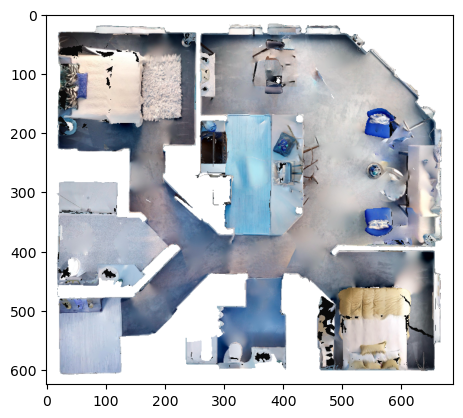

In [23]:
imggraph = ImgGraph()
objgraph = ObjGraph()
positions = []
rotations = []
topdownmap = ortho_map.copy()
obs = sim.get_sensor_observations()
rgb = np.concatenate([obs['panoramic_rgb_part_sensor_%d' % (i)][:, :, :3] for i in range(num_of_camera)], 1)
semantic_array = np.concatenate([obs['panoramic_semantic_part_sensor_%d' % (i)] for i in range(num_of_camera)], 1)
depth_array = np.concatenate([obs['panoramic_depth_part_sensor_%d' % (i)] for i in range(num_of_camera)], 1)
bboxes, bbox_categories, bbox_ids, bbox_depth, bbox_pose = get_objects(semantic_array, mapping, depth_array, rgb.shape[1], rgb.shape[0])

position = sim.get_agent(0).get_state().position
rotation = sim.get_agent(0).get_state().rotation.components
cur_map_coord = to_grid(position[0], position[2])[::-1]
cur_map_rot = get_map_angle(sim.get_agent(0).get_state().rotation)
image_feat = get_image_feat(rgb, depth_array).cpu().detach().numpy()
object_feat = []
if len(bboxes) > 0:
    object_feat = get_object_feat(rgb, bboxes).cpu().detach().numpy()
position = sim.get_agent(0).get_state().position
rotation = sim.get_agent(0).get_state().rotation.components
imggraph.reset()
imggraph.initialize_graph(image_feat[0], position, rotation)
objgraph.reset()
if len(bboxes) > 0:
    objgraph.initialize_graph(object_feat, np.ones(len(bboxes)), bbox_categories,np.ones(len(bboxes)), bbox_pose)
topdownmap = draw_agent(topdownmap, cur_map_coord, cur_map_rot)

cv2.imshow(f'vis', rgb[:, :, [2, 1, 0]])
cv2.imshow(f'graph', topdownmap[::2, ::2, [2, 1, 0]])

topdownmaps = []
images = []
t = 0
while True:
    topdownmap = ortho_map.copy()
    key = cv2.waitKey(0)
    position = sim.get_agent(0).get_state().position
    rotation = sim.get_agent(0).get_state().rotation.components
    cur_map_coord = to_grid(position[0], position[2])[::-1]
    cur_map_rot = get_map_angle(sim.get_agent(0).get_state().rotation)
    positions.append(position)
    rotations.append(rotation)
    if key == ord('w'):
        step(1)
    elif key == ord('a'):
        step(2)
    elif key == ord('d'):
        step(3)
    elif key == ord('q'):
        cv2.destroyAllWindows()
        plt.imshow(topdownmap[::2, ::2, [2, 1, 0]])
        break
    obs = sim.get_sensor_observations()
    rgb = np.concatenate([obs['panoramic_rgb_part_sensor_%d' % (i)][:, :, :3] for i in range(num_of_camera)], 1)
    semantic_array = np.concatenate([obs['panoramic_semantic_part_sensor_%d' % (i)] for i in range(num_of_camera)], 1)
    depth_array = np.concatenate([obs['panoramic_depth_part_sensor_%d' % (i)] for i in range(num_of_camera)], 1) / 10.
    bboxes, bbox_categories, bbox_ids, bbox_depth, bbox_pose = get_objects(semantic_array, mapping, depth_array, rgb.shape[1], rgb.shape[0])

    image_feat = get_image_feat(rgb, depth_array).cpu().detach().numpy()
    object_feat = []
    if len(bboxes) > 0:
        object_feat = get_object_feat(rgb, bboxes).cpu().detach().numpy()
    
    imggraph = update_image_graph(imggraph, objgraph, image_feat[0], object_feat, np.ones(len(bboxes)), bbox_categories, 
                                  position, rotation, time=t, done=False)
    
    if len(bboxes) > 0:
        objgraph = update_object_graph(imggraph, objgraph, object_feat, np.ones(len(bboxes)), bbox_categories, np.ones(len(bboxes)), 
                                       bbox_pose, time=t, done=False)
        
    topdownmap = draw_graph_on_map(topdownmap, imggraph, objgraph)
    topdownmap = draw_agent(topdownmap, cur_map_coord, cur_map_rot)
    rgb = draw_bbox(rgb, bboxes)
    topdownmaps.append(topdownmap)
    images.append(rgb)
    cv2.imshow(f'vis', rgb[:, :, [2, 1, 0]])
    cv2.imshow(f'graph', topdownmap[::2, ::2, [2, 1, 0]])    
    t = t + 1    
topdownmaps = np.stack(topdownmaps)
images = np.stack(images)

In [24]:
def init():
    im.set_data(topdownmaps[0])

def animate(i):
    im.set_data(topdownmaps[i])
    return im

In [25]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)

im = plt.imshow(topdownmaps[0])
plt.close() # this is required to not display the generated image
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=topdownmaps.shape[0], interval=50)
HTML(anim.to_html5_video())

In [26]:
writergif = animation.PillowWriter(fps=20) 
anim.save(os.path.join(project_dir, "demo/tsgm_demo_topdownmap.gif"), writer=writergif)

In [27]:
def init_rgb():
    im.set_data(images[0])

def animate_rgb(i):
    im.set_data(images[i])
    return im

In [28]:
fig2 = plt.figure(figsize=(10,4))
plt.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
im = plt.imshow(images[0])
plt.close() # this is required to not display the generated image
anim = animation.FuncAnimation(fig2, animate_rgb, init_func=init_rgb, frames=images.shape[0], interval=50)
HTML(anim.to_html5_video())

In [29]:
writergif = animation.PillowWriter(fps=20) 
anim.save(os.path.join(project_dir, "demo/tsgm_demo_obs.gif"), writer=writergif)